#  Variational Autoencoders

### **Objective**

This homework focuses on creating variational autoencoders applied to the MNIST dataset.

In [30]:
import torch
torch.rand(5, 3)

tensor([[0.0375, 0.8173, 0.3765],
        [0.1843, 0.7964, 0.8785],
        [0.0700, 0.6982, 0.8093],
        [0.7427, 0.0362, 0.8459],
        [0.8597, 0.1131, 0.4772]])

### **Part 1 - Datasets and Dataloaders**

In [31]:
!mkdir hw9_data

mkdir: cannot create directory ‘hw9_data’: File exists


In [32]:
from torchvision import datasets, transforms

#transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
transformations = transforms.Compose([transforms.ToTensor(),]) 
mnist_train = datasets.MNIST("hw9_data", train=True, transform=transformations, target_transform=None, download=True)
mnist_test = datasets.MNIST("hw9_data", train=False, transform=transformations, target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21689809.18it/s]                            


Extracting hw9_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 329701.30it/s]
0it [00:00, ?it/s]

Extracting hw9_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5197448.22it/s]                           
8192it [00:00, 132254.07it/s]


Extracting hw9_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting hw9_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=True, num_workers=2)

## Part 2 - Encoder and Decoders 

### For the Encoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, 28,28)**
*  **forward() should return two tensors of size latent_dim like a standard encoder of a VAE**
* **One of the tensors should correspond to the mean of the encoding and the other tensor should correspond to the variance. In practice, it is easier to model the output as the log of the variance (logvar) and we will too**

### For the Decoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, latent_dim)**
*  **forward() should return a tensor of shape (batch_size, 28,28)**
* **Make sure that the output lies in the same range as the input to the encoder (Hint: Sigmoid?)**







In [0]:
from torch import nn
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    self.lin1 = nn.Linear( input_dim, hidden_dim)
    self.mean = nn.Linear(hidden_dim,latent_dim)    
    self.logvar = nn.Linear(hidden_dim, latent_dim)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    ## YOUR CODE HERE ##
    x = x.view(-1, 28*28)
    x = self.lin1(x)
    x = self.relu(x)
    out_mu = self.mean(x)
    out_logvar = self.logvar(x)
    return out_mu, out_logvar
     

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, out_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    self.latent_dim = latent_dim
    self.out_dim = out_dim
    self.lin1 = nn.Linear(latent_dim, out_dim)    
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(hidden_dim, out_dim)    
    self.sigmoid =  nn.Sigmoid()
    
  def forward(self,x):
    ## YOUR CODE HERE ##
    x = x.view(-1, self.latent_dim)
    x = self.lin1(x)
#     x = self.relu(x)
#     x = self.lin2(x)
    return self.sigmoid(x) 

## **Part 3: Training and loss functions**


In [0]:
import numpy as np
def sample(mu, logvar):
  ## YOUR CODE HERE ##
  std = torch.exp(.5*logvar)
  #randn like returns normal of mean 0, var 1, size std.size
  e= torch.randn_like(std)
  return mu + std*e

In [0]:
from torch.nn.functional import kl_div, mse_loss
def vae_loss(x, x_hat, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
  batch_size = 32
  MSE = mse_loss(x_hat, x)
  KL = -.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
  KL /= 28 * 28 * batch_size
  return MSE + KL

In [0]:
from torch import optim

## YOUR CODE HERE ##
encoder = Encoder(28*28, 16, 32)
decoder = Decoder(32, 16, 28 * 28)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

Complete the train function that takes input encoder, decoder, train_loader, optimizer, and number of epochs you wish to train your model for.

Training will involve:

1.   **One epoch is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2.   **For each batch, use the encoder to generate the mu and logvar.**
3. **Sample a latent vector for each image in the batch and feed this to the decoder to generate the decoded images.**
4. **Calculate the loss function for this batch.**
5. **Now calculate the gradients for each parameter you are optimizing over. (Hint: Your loss function object can do this for you)**
6. **Update your model parameters (Hint: The optimizer comes in here)**
7. ** Set the gradients in your model to zero for the next batch.**



In [0]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10):
  accuracy_training = []
  accuracy_test = []
  loss_training = []
  loss_test = []
  count = 0  
  batch_size = 32
  encoder.train()
  decoder.train()
  for epoch in range(num_epochs):
  #training
    print("epoch: ", epoch)
    net_loss = 0.0
    for counter, (features, classes) in enumerate(train_loader):
      optimizer.zero_grad()
      features = features.view(-1, 784)
      mu, logvar = encoder(features)
      out = decoder(sample(mu, logvar))
      loss = vae_loss(out, features, mu, logvar)
      loss.backward()
      net_loss += loss.data.item()
      #print((loss.data).item())
      optimizer.step()
      count += 1
    print(f'Loss: {net_loss/len(train_loader)}')

Finally call train with the relevant parameters.

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand.

In [39]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 10)

epoch:  0
Loss: 0.0759901990433534
epoch:  1
Loss: 0.059564165876309076
epoch:  2
Loss: 0.05565860556562741
epoch:  3
Loss: 0.052881163171927134
epoch:  4
Loss: 0.05112057556907336
epoch:  5
Loss: 0.050267110017935435
epoch:  6
Loss: 0.04979243232409159
epoch:  7
Loss: 0.04936291617155075
epoch:  8
Loss: 0.048988294170300165
epoch:  9
Loss: 0.048776082235574725


## **Part 4: Visualizing the VAE output** 

We will look at how well the codes produced by the VAE can be interpolated. **For this section we will only use the MNIST test set. **

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We now consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

Complete the interpolation function below that takes a pair of images A and B and returns 9 images. (You are free to use any data structure you want to return these images)

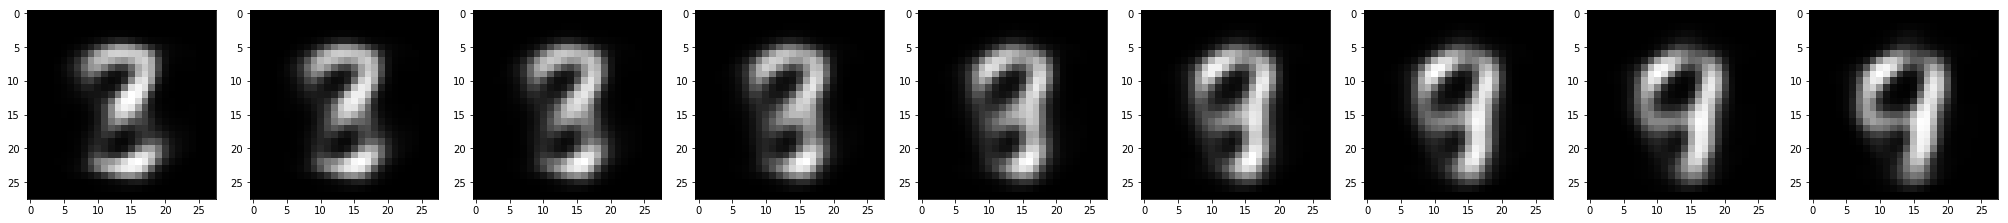

In [40]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def show(img):
    npimg = img.numpy()
    fig, axeslist = plt.subplots(ncols= npimg.shape[0], nrows=1, figsize = (28, 28))
    for i in range(npimg.shape[0]):
      axeslist[i].imshow(npimg[i], cmap = "gray")
    plt.tight_layout()
    plt.show()


def create_interpolates(A, B, encoder, decoder):
  ## YOUR CODE HERE ##
  n_interps = 9
  with torch.no_grad():
    mu1, logvar1 = encoder(A)
    mu2, logvar2 = encoder(B)
    muvals = np.zeros([n_interps, mu1.size()[1]])
    test_mu1 = decoder(mu1)
    test_mu2 = decoder(mu2)
  

    for i in range(0, mu1.size()[1]):
      muvals[:, i] = (np.linspace(mu1[0][i], mu2[0][i], n_interps)).astype(np.float32)
    imgs = []
    for i in range(n_interps):
      var = muvals[i, :]
      img = decoder(torch.from_numpy(var).type(torch.FloatTensor))
      imgs.append(img)
      
    grid = utils.make_grid(imgs)
    show(grid.reshape(-1, 28,28))
    return

for i, batch in enumerate(test_loader):
    if i==1:
        break
    plt.show()
    plt.show()

    create_interpolates(batch[0][0], batch[0][1], encoder, decoder)
   

**For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows (1 row per digit) and 9 columns (7 interpolates + 2 selected test images) of images. (45 points)**

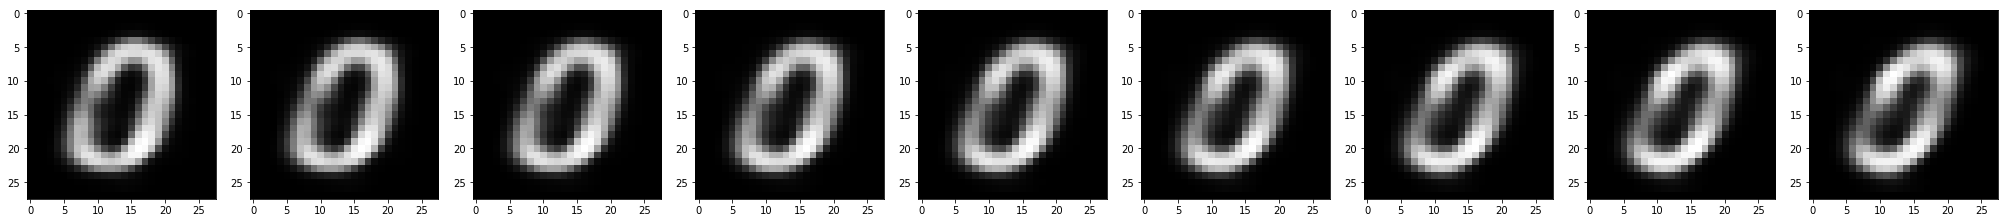

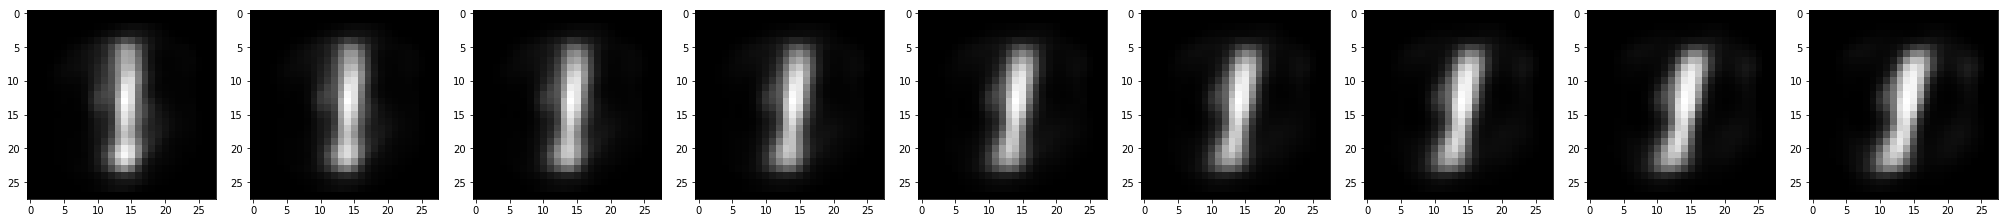

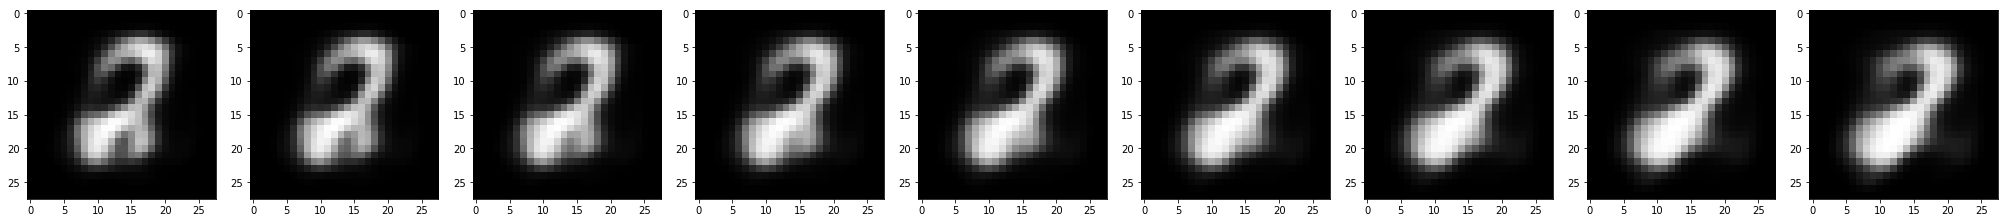

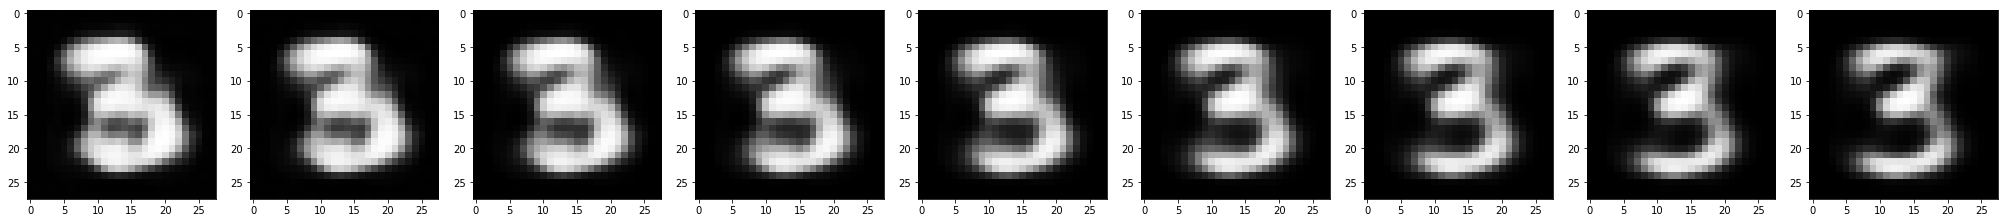

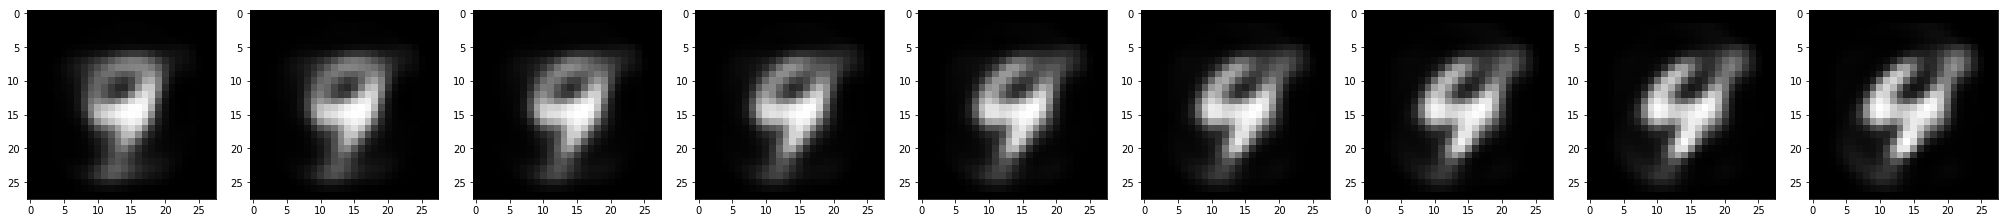

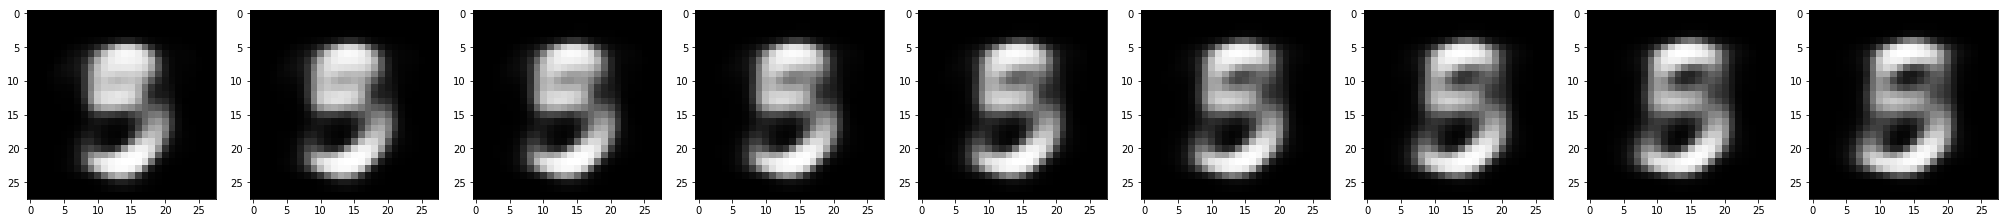

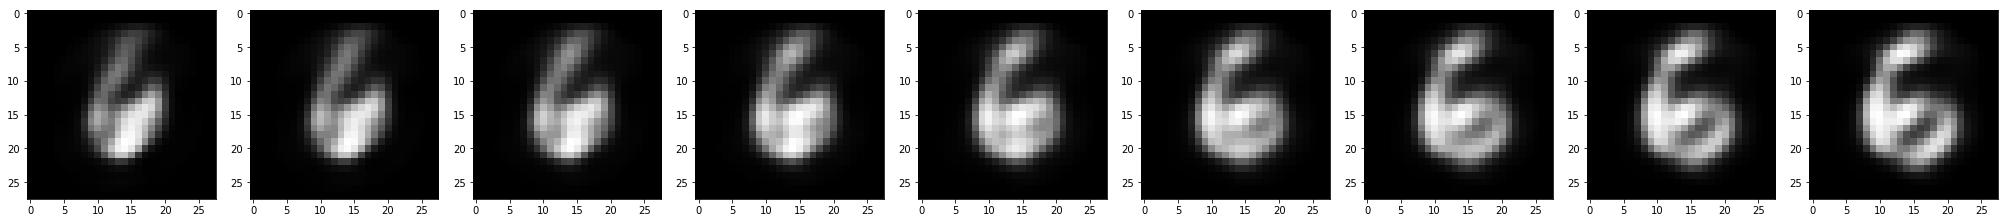

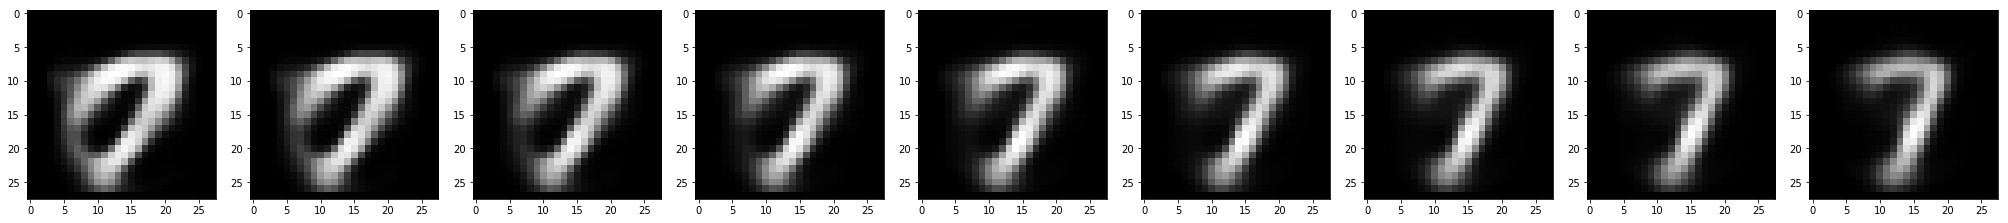

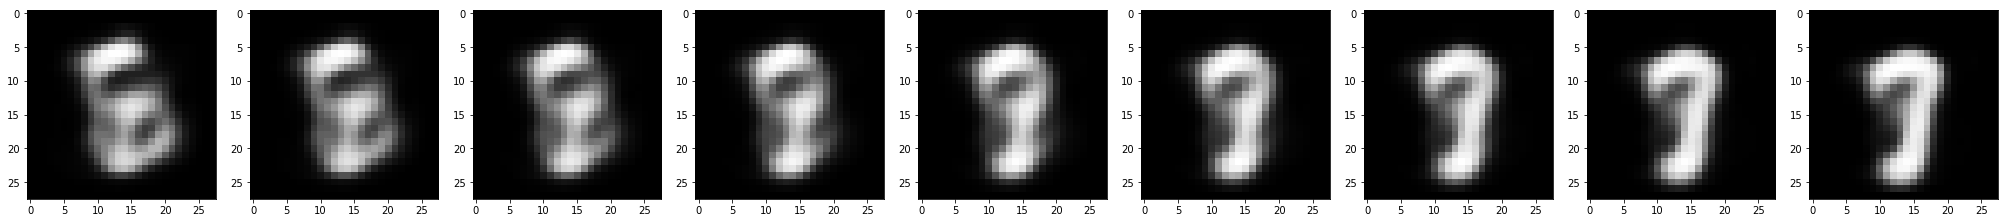

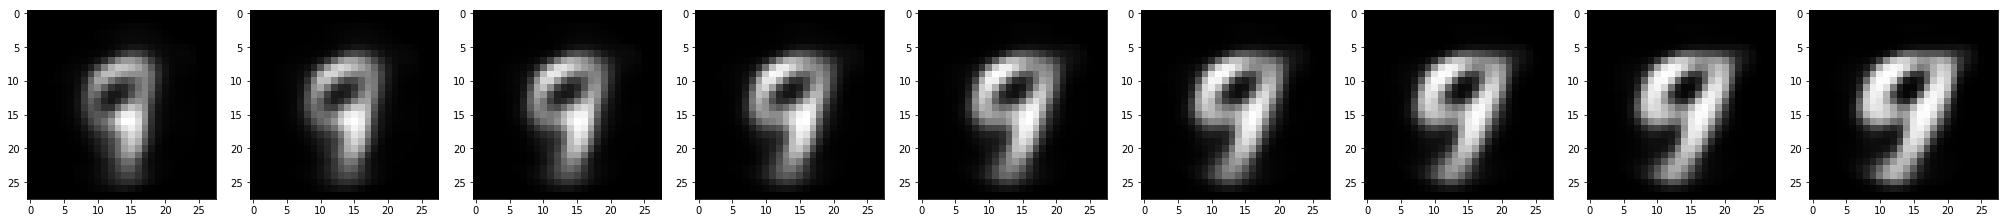

<Figure size 432x288 with 0 Axes>

In [41]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

## YOUR CODE HERE ##
for i in range(len(similar_pairs)):
  A = similar_pairs[i][0]
  B = similar_pairs[i][1]
  create_interpolates(A,B,encoder,decoder)
  
plt.savefig("same_interp")

**For 10 pairs of MNIST test images, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images. (45 points)**

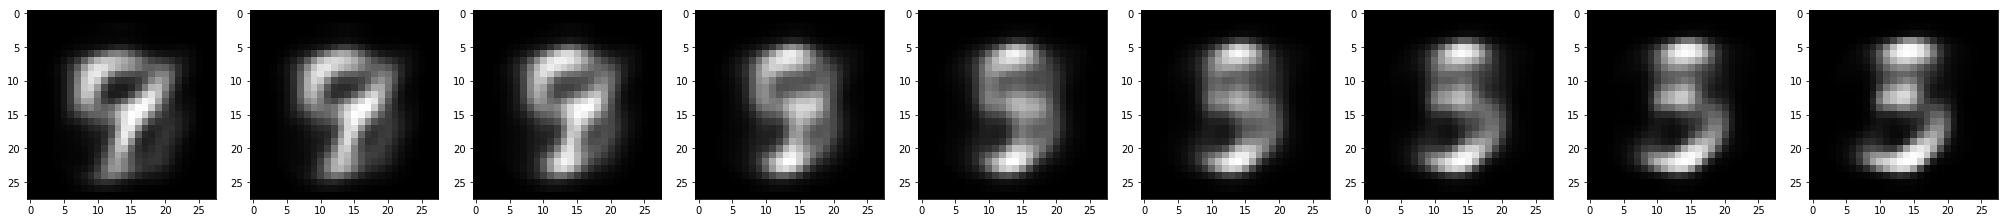

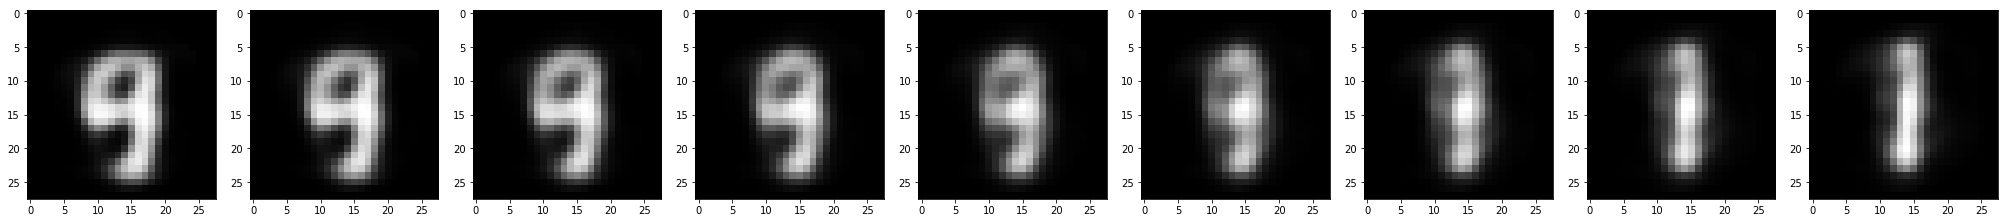

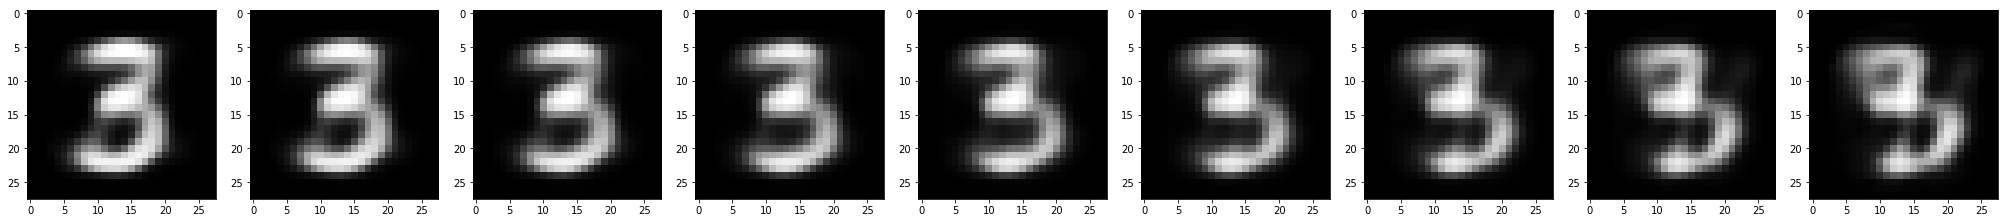

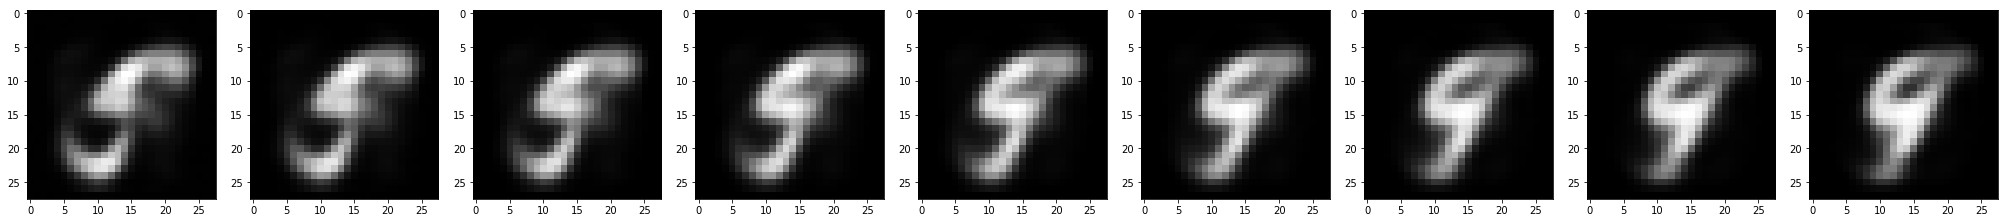

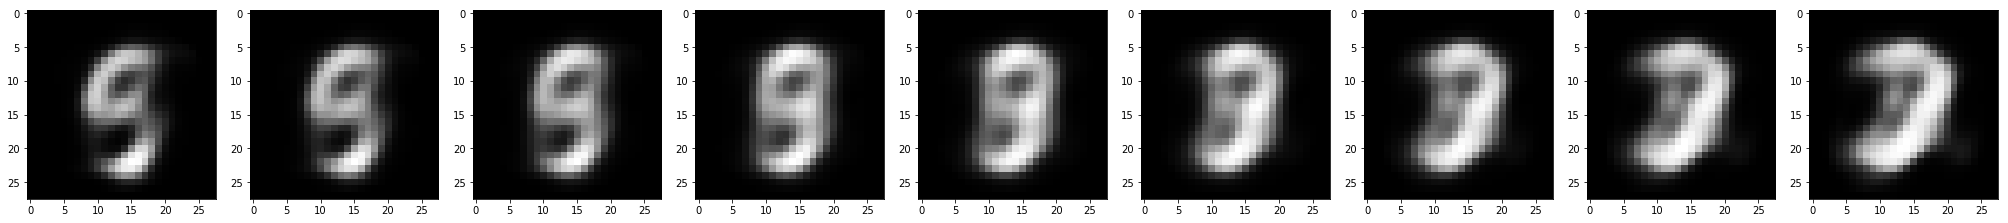

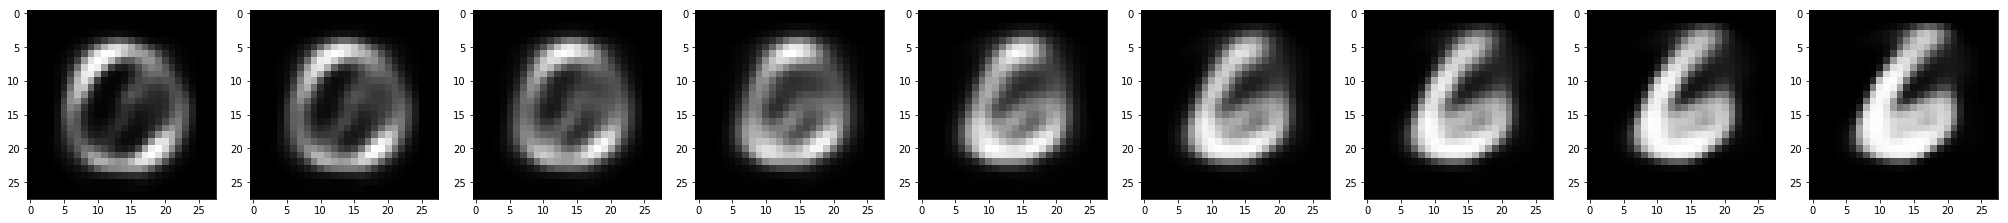

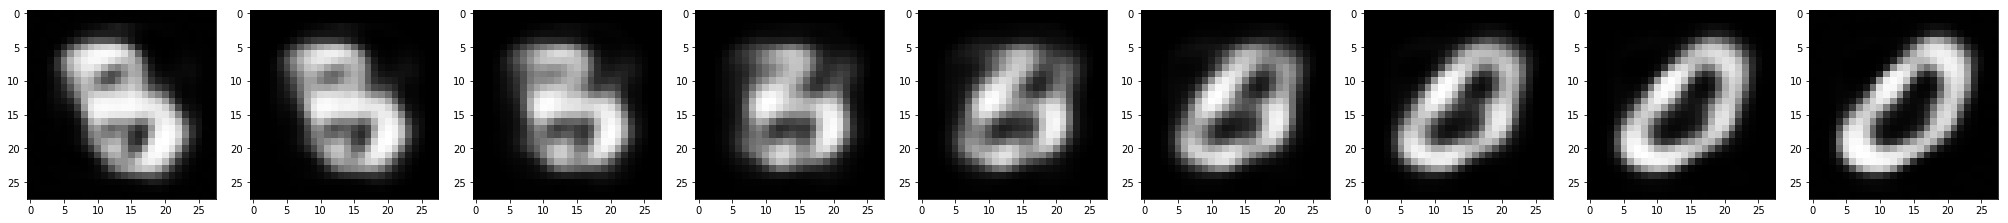

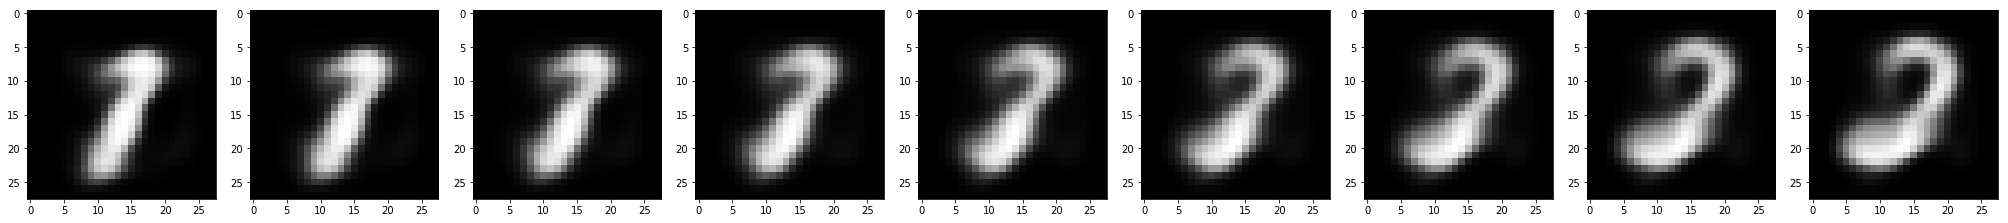

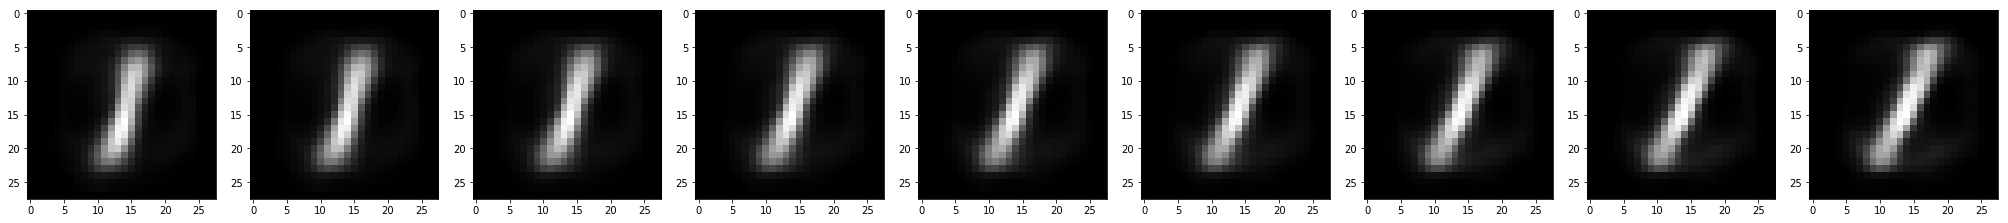

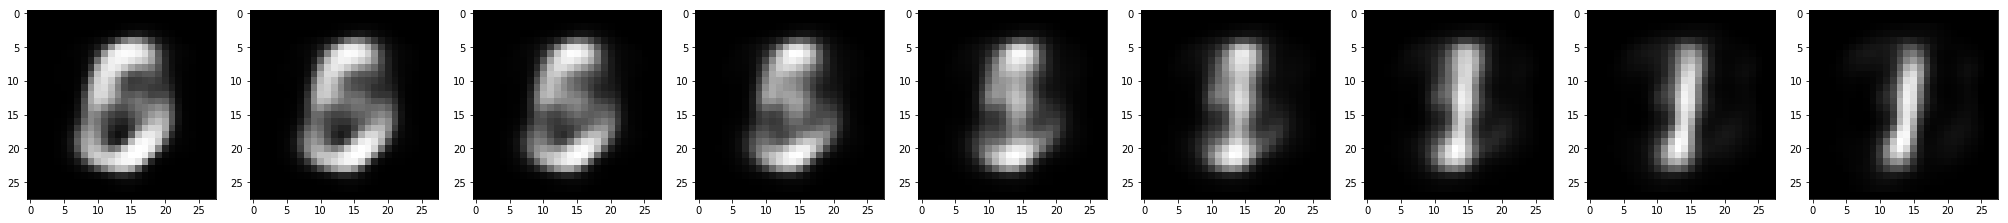

In [42]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  # Make sure the batch size is greater than 20
  for i in range(10):
    random_pairs[i] = []
    random_pairs[i].append(x[2*i])
    random_pairs[i].append(x[2*i+1])
  break

# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

## YOUR CODE HERE ##
for i in range(len(random_pairs)):
  A = random_pairs[i][0]
  B = random_pairs[i][1]
  create_interpolates(A,B,encoder,decoder)
  
plt.savefig("rand_interp")